# Maximizing the Sharpe Ratio via the Efficient Frontier (Markowitz Sweep)


The Sharpe ratio is a measure of risk-adjusted return. It tells you how much excess return you're earning per unit of risk. It can be defined as:
$$
S = \frac{R_p - R_f}{\sigma_p}
$$

where

- $R_p$ is the expected return of the portfolio,
- $R_f$ is the risk-free rate,
- $\sigma_p$ is the standard deviation of the portfolio's returns.

In contrast to the Markowitz model, Sharpe optimization picks the best trade-off directly. We don't only want high returns, but high return relative to the risk taken.

Given 

- $\mu \in \mathbb{R}^n$: expected returns, 
- $\Sigma \in \mathbb{R}^{n \times n}$: covariance matrix of returns,
- $R_f \in \mathbb{R}$: risk-free rate,
- $w \in \mathbb{R}^n$: portfolio weights,
the Sharpe ratio of the portfolio w is:
$$
S(w) = \frac{\mu^T w - R_f}{\sqrt{w^T \Sigma w}}
$$

This gives us the optimization problem:

$$
\max_{w \in \mathbb{R}^n} S(w) = \max_{w \in \mathbb{R}^n} \frac{\mu^T w - R_f}{\sqrt{w^T \Sigma w}} \quad \text{subject to }  \quad \sum_{i=1}^n w_i = 1, \quad w_i \geq 0 \text{ for all } i
$$

Notice that because of the square root in the denominator, this is a fractional non-convex optimization problem, and we will solve it via Markowitz Sweep.

### Markowitz Sweep
The Markowitz Sweep is a method to solve the Sharpe ratio optimization problem by transforming it into a series of linear problems. The idea is to sweep through different levels of the Sharpe ratio and find the optimal portfolio weights for each level.
The Sharpe optimal portfolio lies on the efficient frontier. By solving the Markwitz optimization problem for a range of target returns, we can compute the risk and return of each portfolio, evaluate its Sharpe ratio, and simply pick the portfolio with the highest Sharpe ratio.

Mathematically, we solve
$$
\min_{w \in \mathbb{R}^n} w^T \Sigma w \quad \text{subject to } \mu^T w = R, \quad \sum_{i=1}^n w_i = 1, \quad w_i \geq 0 \text{ for all } i
$$

Each solution gives us:

- Return: $\mu^T w$
- Risk: $\sqrt{w^T \Sigma w}$
- Sharpe: $\frac{\mu^T w - R_f}{\sqrt{w^T \Sigma w}}$.

But why does this even work? This follows directly from the geometry of the efficient frontier. Its the set of portfolios with minimum variance for a given return. The tangency point between the capital market line and the frontier is the Sharpe-maximizing portfolio.

In [1]:
import numpy as np 
import cvxpy as cp 
import matplotlib.pyplot as plt

=== Maximum Sharpe Ratio Portfolio ===
Sharpe Ratio:       0.4125
Expected Return:    8.14%
Portfolio Risk:     14.89%

Asset Allocation:
  Asset 1:     17.91%
  Asset 2:     39.82%
  Asset 3:     7.63%
  Asset 4:     34.64%


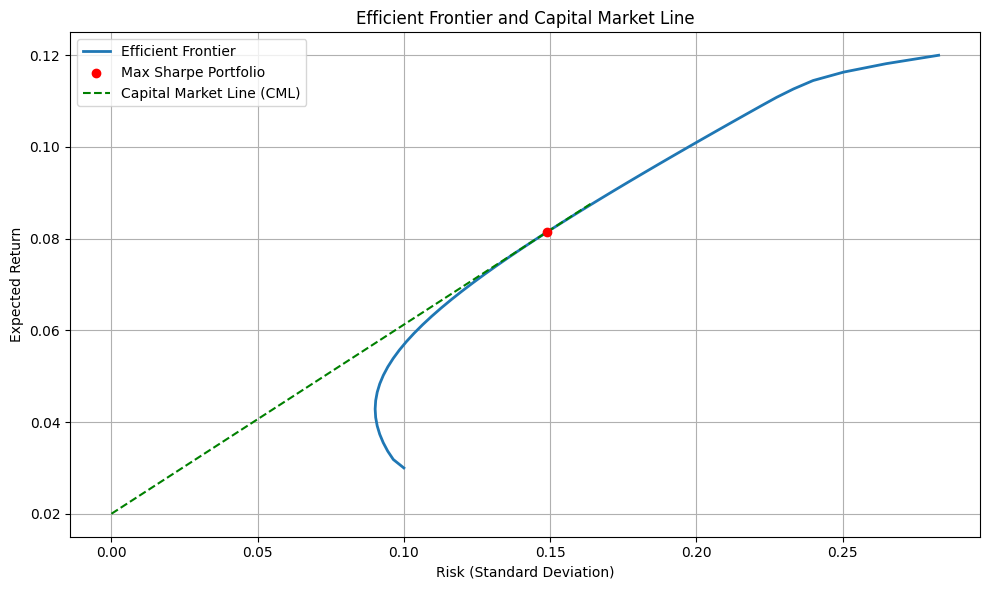

In [ ]:
# Number of assets
n = 4

# Expected returns
mu = np.array([0.1, 0.12, 0.07, 0.03])

# Covariance matrix
Sigma = np.array([
    [0.1, 0.02, 0.04, 0.00],
    [0.02, 0.08, 0.01, 0.00],
    [0.04, 0.01, 0.09, 0.00],
    [0.00, 0.00, 0.00, 0.01]
])

# Risk-free rate
rf = 0.02

min_mu = np.min(mu)
max_mu = np.max(mu)

r_targets = np.linspace(min_mu, max_mu, 50)

returns = []
risks = []
weights = []

for r in r_targets:
	# Define optimization variables
	w = cp.Variable(n)

	# Define the objective function (maximize return)
	objective = cp.Minimize(cp.quad_form(w, Sigma))

	# Define constraints
	constraints = [
		cp.sum(w) == 1,
		w >= 0,
		mu @ w == r
	]

	# Solve the problem
	problem = cp.Problem(objective, constraints)
	problem.solve()

	if w.value is not None:
		w_val = w.value
		risk = np.sqrt(w_val.T @ Sigma @ w_val)
		risks.append(risk)
		returns.append(mu @ w_val)
		weights.append(w_val)
	else:
		returns.append(np.nan)
		risks.append(np.nan)
		weights.append(np.full(n, np.nan))

# Convert lists to numpy arrays
returns = np.array(returns)
risks = np.array(risks)
weights = np.array(weights)

Sharpe_values = (returns - rf) / risks

index_max = np.nanargmax(Sharpe_values)

weight = weights[index_max]
risk = risks[index_max]
return_ = returns[index_max]

print("=== Maximum Sharpe Ratio Portfolio ===")
print(f"Sharpe Ratio:       {round(Sharpe_values[index_max], 4)}")
print(f"Expected Return:    {round(return_ * 100, 2)}%")
print(f"Portfolio Risk:     {round(risk * 100, 2)}%")
print("\nAsset Allocation:")
for i, w in enumerate(weight):
    print(f"  Asset {i + 1}:     {round(w * 100, 2)}%")

# Capital Market Line setup
slope = Sharpe_values[index_max]  # Sharpe ratio
cml_x = np.linspace(0, risks[index_max] * 1.1, 100)
cml_y = rf + slope * cml_x

# Plot
plt.figure(figsize=(10, 6))

# Efficient Frontier
plt.plot(risks, returns, label="Efficient Frontier", linewidth=2)

# Max Sharpe Portfolio
plt.scatter(risks[index_max], returns[index_max], color='red', zorder=5, label="Max Sharpe Portfolio")

# Capital Market Line
plt.plot(cml_x, cml_y, '--', color='green', label="Capital Market Line (CML)")

# Formatting
plt.title("Efficient Frontier and Capital Market Line")
plt.xlabel("Risk (Standard Deviation)")
plt.ylabel("Expected Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
	




